FFSI ML Risk Management Alerting System

This notebook implements the machine learning component of our Risk Management Alerting System  for wealth management clients.

Our Project Goal
Our primary objective is to *forecast future volatility* for a set of stock holdings. We will be using this forecast to trigger automated, daily email alerts to clients to inform them about the risk level of their stocks (as predicted by this ML) compared to their predefined threshold. This moves communication beyond traditional weekly or quarterly reports, enabling clients to make decisions based on near real-time information with speed and transparency.

ML Methodology
The system we implemented employs a Random Forest Regressor to predict the future 30-day realized volatility (future_volatility) of a stock *based on its historical features*. The key steps in this notebook are:
1. Data Acquisition: we started off by downloading 3 years of daily historical pricing data for *selected stocks and benchmarks (S&P 500) using the yfinance API*.
2. Feature Engineering: we calculate fundamental technical analysis features, such as rolling volatility, momentum, Average True Range (ATR), and Beta, over a 30-day window.
3. Model Training: we chose *RandomizedSearchCV* for hyperparameter tuning with the goal to find an optimal and production-ready model that minimizes Mean *Absolute Error (MAE)*.
4. Deployment Preparation: here we export the final model object and its required feature list for *deployment on AWS Lambda*, as part of our larger AWS architecture to implement the Risk Management Alerting System.

In [1]:
#In this cell we import all Python libraries necessary for every stage of the project

import yfinance as yf
import pandas as pd
from tqdm import tqdm
import datetime as dt

1. Data Acquisition

This section handles the data acquisition step, gathering the data serving as the historical dataset for training the Random Forest model.

It defines the assets and time period, and then uses the yfinance library to download daily price data for each:

- The selection includes a mix of large-cap tech stocks (AAPL, MSFT, GOOG, NVDA), high-growth/volatile stocks (TSLA, RIOT, AMC), and more traditional companies (PEP). Here we made the conscious choice to include stocks with "relatively high volatility" as to predict and alert on risk.
- We chose a timeline of 3 years (corresponding to approximately 750 trading days) as to provide a sufficient window of historical data (365*3 days) to calculate robust rolling-window features (like 30-day volatility and Beta) and training the ML model. The feature engineering relies on past data, making a large, fixed history necessary. The training data will leverage historical performance.
- We chose the  S&P 500 (^GSPC) for our benchmarks, which we use to later calculate the Beta feature, a key measure of systematic risk relative to the overall market.

In [2]:
#tickers selected for the model training set
tickers = [
    "AAPL", "MSFT", "GOOG", "TSLA",
    "CRM", "PLTR", "MSTR", "UBER", "PEP",
    "NVDA", "RIOT", "AMC" #relatively high volatility
]

#our main benchmark for comparison and Beta calculation (S&P 500)
benchmark_main = "^GSPC"
#an additional benchmark (Russell 2000), included for potential optional features
benchmark_extra = "^RUT"

#here we define the start date as 3 years ago, converted to YYYY-MM-DD string format
start = (dt.datetime.today() - dt.timedelta(days=365*3)).strftime("%Y-%m-%d")
#and the end date as of today
end = dt.datetime.today().strftime("%Y-%m-%d")

df_dict = {}
#using tqdm to make a progress bar for data download loop
for ticker in tqdm(tickers):
    #auto_adjust=False keeps the raw 'open', 'high', 'low', 'close', and 'adj close' columns, preserving the raw pricing info
    df = yf.download(ticker, start=start, end=end, interval="1d", auto_adjust=False)

    #here we fix the multi index as when downloading data for a single ticker sometimes yfinance might return a pandas multi index where columns are nested tuples, like ('Close', 'AAPL')
    #so this structure breaks simple indexing and feature engineering by only selecting the first element of the tuple
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]

    #adding ticker column
    df["ticker"] = ticker
    df_dict[ticker] = df

#downloading benchmarks
df_sp500 = yf.download(benchmark_main, start=start, end=end, interval="1d", auto_adjust=False)
if isinstance(df_sp500.columns, pd.MultiIndex):
    df_sp500.columns = [col[0] for col in df_sp500.columns]

df_rut = yf.download(benchmark_extra, start=start, end=end, interval="1d", auto_adjust=False)
if isinstance(df_rut.columns, pd.MultiIndex):
    df_rut.columns = [col[0] for col in df_rut.columns]

print("Download complete.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
100%|██████████| 12/12 [00:04<00:00,  2.46it/s]
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 o

Download complete.


Quick data inspection to verify the data structure, columns, and size

In [3]:
df.head()

,Adj Close,Close,High,Low,Open,Volume,ticker
Date,,,,,,,
2022-12-05,74.500000,74.500000,85.400002,74.099998,81.800003,2831340,AMC
2022-12-06,67.500000,67.500000,74.800003,66.800003,74.599998,2618810,AMC
2022-12-07,60.500000,60.500000,71.300003,60.000000,67.699997,3923440,AMC
2022-12-08,60.700001,60.700001,67.000000,59.700001,62.400002,3049640,AMC
2022-12-09,59.400002,59.400002,61.299999,58.099998,60.500000,2315640,AMC


In [4]:
df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ticker'], dtype='object')

In [5]:
df.shape

(752, 7)

In [6]:
df_sp500.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2022-12-05,3998.840088,3998.840088,4052.449951,3984.489990,4052.020020,4280820000
2022-12-06,3941.260010,3941.260010,4001.510010,3918.389893,3996.629883,4368380000
2022-12-07,3933.919922,3933.919922,3957.570068,3922.679932,3933.280029,4118050000
2022-12-08,3963.510010,3963.510010,3974.189941,3935.830078,3947.790039,4006900000
2022-12-09,3934.379883,3934.379883,3977.020020,3933.040039,3954.169922,3888260000


In [7]:
df_rut.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2022-12-05,1840.219971,1840.219971,1886.010010,1834.420044,1886.010010,4280820000
2022-12-06,1812.579956,1812.579956,1839.540039,1802.949951,1839.540039,4368380000
2022-12-07,1806.900024,1806.900024,1822.699951,1805.660034,1809.170044,4118050000
2022-12-08,1818.290039,1818.290039,1833.750000,1808.849976,1815.709961,4006900000
2022-12-09,1796.660034,1796.660034,1815.810059,1796.660034,1812.150024,3888260000


In [8]:
df_list = []

for ticker in tickers:
    df = df_dict[ticker].copy()

    #here we standardize names with lowercase and underscore for consistency
    df = df.rename(columns={
        "Open": "open",
        "High": "high",
        "Low": "low",
        "Close": "close",
        "Adj Close": "adj_close",
        "Volume": "volume"
    })

    #we establish that if adj close is missing we fallback to close
    #adj close (adjusted for splits/dividends) would be the preferred price for accurate return calculations, but if notavailable we set to fall back to 'close'
    if "adj_close" not in df.columns:
        df["adj_close"] = df["close"]

    #creating date column for potential future indexing
    df["date"] = df.index
    #select and ordering the key columns for the model and dropping rows with missing data
    df = df[["date", "open", "high", "low", "close", "adj_close", "volume", "ticker"]]
    df = df.dropna()

    #we calculate daily return as the pct change in adjusted closing price, this is the base series from which all our volatility-based features and the target variable will be derived
    df["return"] = df["adj_close"].pct_change()

    df_list.append(df)
#finally we concatenate all stock DataFrames into one
df_all = pd.concat(df_list, ignore_index=True)

#same process for benchmarks to ensure compatibility for the Beta calculation in the feature engineering step
df_sp = df_sp500.rename(columns={
    "Open": "open", "High": "high", "Low": "low",
    "Close": "close", "Adj Close": "adj_close", "Volume": "volume"
})
df_sp["date"] = df_sp.index
if "adj_close" not in df_sp.columns:
    df_sp["adj_close"] = df_sp["close"]
df_sp["return"] = df_sp["adj_close"].pct_change()
df_sp = df_sp[["date","open","high","low","close","adj_close","volume","return"]]

df_rut_clean = df_rut.rename(columns={
    "Open": "open", "High": "high", "Low": "low",
    "Close": "close", "Adj Close": "adj_close", "Volume": "volume"
})
df_rut_clean["date"] = df_rut_clean.index
if "adj_close" not in df_rut_clean.columns:
    df_rut_clean["adj_close"] = df_rut_clean["close"]
df_rut_clean["return"] = df_rut_clean["adj_close"].pct_change()
df_rut_clean = df_rut_clean[["date","open","high","low","close","adj_close","volume","return"]]

print(df_all.shape)
df_all.head()

(9024, 9)


,date,open,high,low,close,adj_close,volume,ticker,return
0,2022-12-05,147.770004,150.919998,145.770004,146.630005,144.450821,68826400,AAPL,NaN
1,2022-12-06,147.070007,147.300003,141.919998,142.910004,140.786057,64727200,AAPL,-0.025370
2,2022-12-07,142.190002,143.369995,140.000000,140.940002,138.845352,69721100,AAPL,-0.013785
3,2022-12-08,142.360001,143.520004,141.100006,142.649994,140.529953,62128300,AAPL,0.012133
4,2022-12-09,142.339996,145.570007,140.899994,142.160004,140.047211,76097000,AAPL,-0.003435


In [ ]:
#We collect each client's preferred risk level through a short questionnaire, and internally convert it to a volatility threshold. The ML model forecasts future daily volatility and triggers alerts if the predicted risk exceeds this client-specific threshold.

2. Feature Engineering
This section defines the 30-day window used for all calculations. A 30-day lookback/lookahead window smooths out daily noise and captures medium-term trends in risk and momentum, which we found relevant for wealth management decision-making. The code then iterates through each stock to generate nine different historical features and one future target variable.

Historical features:
1. Rolling volatility: the standard deviation of daily returns over the last 30 days.
    This is the most direct historical measure of instability or risk. Stocks that have been highly volatile recently often remain volatile in the near future.
2. Rolling momentum: thetotal percentage price change over the last 30 days.
    Why it matters for us:
    It measures the strength and direction of the recent trend. Strong momentum (either up or down) can indicate continuation, which often influences the expected volatility..
3. Max drawdown: the biggest percentage loss from the highest point in the last 30 days.
    This is crucial to measure capital preservation risk. It quantifies the worst-case scenario a client would have faced recently.
4. ATR (Average True Range): the average daily trading range over 30 days, incorporating price gaps (where today's open is far from yesterday's close).
    This measures volatility based on how much the price moves in a full day. It captures sharp, sudden moves better than a simple daily return calculation.
5. Avg volume: the mean daily trading volume over the last 30 days.
    High volume often implies liquidity and wide investor interest. Low volume can signal a "thinly traded" stock that might experience sudden, high-volatility moves.
6. Volume volatility: the variability (standard deviation) of the daily trading volume over 30 days
    Instability in trading activity can signal unusual market events or shifting interest, often preceding a major price change or risk event.
7. Beta vs S&P500: the stock's sensitivity to movements in the overall market (here we benchmark against the S&P 500).
    This quantifies systematic risk: how much the stock is expected to move when the broader market moves. High Beta means higher risk relative to the market.
8. Price Range Ratio: the size of the daily high-to-low swing compared to the closing price.
    Measures intra-day volatility (the risk within one trading day). A large ratio suggests continuous, high-frequency internal risk.
9. Up/Down ratio: the ratio of positive-return days to negative-return days in the 30-day window.
    This is a simple measure of directional stability. A high ratio (more up days) suggests a strong recent bullish environment (aka with prices expected to rise).

Target variable:
We defined our target variable as the future 30-day realized volatility. We calculated this as the standard deviation of the stock's daily returns over the *next* 30 trading days. This is the variable our model must predict and that we will compare with client's predefined risk treshold. Here the `.shift(-FUTURE_WINDOW)` aligns the target (future risk) with the features (historical context) available on the prediction date.

In [9]:
#lookback period for all features (30 trading days)
WINDOW = 30
#forward-looking period for target variable (next 30 trading days)
FUTURE_WINDOW = 30

feature_rows = []

#converting benchmarks to aligned daily return series
sp = df_sp[["date", "return"]].set_index("date").copy()
sp = sp.sort_index()

for ticker in tickers:
    df = df_all[df_all["ticker"] == ticker].copy()
    df = df.sort_values("date")

    df = df.set_index("date")

    #1) rolling volatility
    df["volatility_30d"] = df["return"].rolling(WINDOW).std()

    #2) rolling momentum
    df["momentum_30d"] = df["adj_close"].pct_change(WINDOW)

    #3) max drawdown
    roll_max = df["adj_close"].rolling(WINDOW).max()
    df["max_drawdown_30d"] = (df["adj_close"] - roll_max) / roll_max

    #4) ATR
    df["prev_close"] = df["adj_close"].shift(1)
    df["tr"] = df[["high","low","prev_close"]].apply(
        lambda row: max(
            row["high"] - row["low"],
            abs(row["high"] - row["prev_close"]),
            abs(row["low"] - row["prev_close"])
        ),
        axis=1
    )
    df["atr_30d"] = df["tr"].rolling(WINDOW).mean()

    #5) avg volume
    df["avg_volume_30d"] = df["volume"].rolling(WINDOW).mean()

    #6) volume volatility
    df["volume_volatility_30d"] = df["volume"].rolling(WINDOW).std()

    #7) beta vs S&P500
    # Align stock + S&P returns
    combined = df[["return"]].join(sp, lsuffix="_stock", rsuffix="_sp", how="left")
    df["covar"] = combined["return_stock"].rolling(WINDOW).cov(combined["return_sp"])
    df["var_sp"] = combined["return_sp"].rolling(WINDOW).var()
    df["beta_30d"] = df["covar"] / df["var_sp"]

    #8) price range ratio
    df["range_ratio"] = (df["high"] - df["low"]) / df["adj_close"]

    #9) up/down ratio
    df["up"] = (df["return"] > 0).astype(int)
    df["down"] = (df["return"] < 0).astype(int)
    df["up_down_ratio"] = df["up"].rolling(WINDOW).sum() / df["down"].rolling(WINDOW).sum()

    # setting target variable
    df["future_volatility"] = df["return"].shift(-FUTURE_WINDOW).rolling(FUTURE_WINDOW).std()

    #readding ticker as column
    df["ticker"] = ticker

    feature_rows.append(df)

#finalizing feature matrix
df_features = pd.concat(feature_rows)
df_features = df_features.dropna()

print("Final feature dataset shape:", df_features.shape)
df_features.head()

Final feature dataset shape: (8304, 24)


,open,high,low,close,adj_close,volume,ticker,return,volatility_30d,momentum_30d,...,avg_volume_30d,volume_volatility_30d,covar,var_sp,beta_30d,range_ratio,up,down,up_down_ratio,future_volatility
date,,,,,,,,,,,,,,,,,,,,,
2023-01-19,134.080002,136.250000,133.770004,135.270004,133.259613,58280400,AAPL,0.000444,0.019268,-0.077474,...,7.883635e+07,1.968291e+07,0.000189,0.000125,1.507870,0.018610,1,0,0.875000,0.016499
2023-01-20,135.279999,138.020004,134.220001,137.869995,135.820984,80223600,AAPL,0.019221,0.019163,-0.035267,...,7.935290e+07,1.950238e+07,0.000191,0.000131,1.459808,0.027978,1,0,1.000000,0.016477
2023-01-23,138.119995,143.320007,137.899994,141.110001,139.012817,81760300,AAPL,0.023500,0.019512,0.001206,...,7.975420e+07,1.942105e+07,0.000200,0.000135,1.474979,0.038989,1,0,1.142857,0.016374
2023-01-24,140.309998,143.160004,140.300003,142.529999,140.411728,66435100,AAPL,0.010063,0.019473,-0.000841,...,7.989776e+07,1.930181e+07,0.000196,0.000134,1.467620,0.020369,1,0,1.142857,0.016350
2023-01-25,140.889999,142.429993,138.809998,141.860001,139.751709,65799300,AAPL,-0.004701,0.019482,-0.002110,...,7.955451e+07,1.946263e+07,0.000196,0.000132,1.485416,0.025903,0,1,1.142857,0.016610


In [10]:
#cleaning the data before feeding into the model to ensure it will rely only on calculated 30-day metrics to make predictions
#also dropping unnecessary columns to optimize size and memory given use of aws lambda

cols_to_drop = [
    "ticker", #dropping identifier
    "open", "high", "low", "close", "adj_close", #dropping raw prices.
    "volume", "return", #dropping raw vol and daily return
    #dropping helper columns used in feature calculations
    "prev_close", "tr", #used for ATR
    "covar", "var_sp", #used for beta
    "up", "down" #used for up/down ratio
]

#making sure to drop in df safely
df_features = df_features.drop(columns=[c for c in cols_to_drop if c in df_features.columns])

print("Remaining columns after drop:")
print(df_features.columns.tolist())

print("\nNumber of rows:", len(df_features))
df_features.head()

Remaining columns after drop:
['volatility_30d', 'momentum_30d', 'max_drawdown_30d', 'atr_30d', 'avg_volume_30d', 'volume_volatility_30d', 'beta_30d', 'range_ratio', 'up_down_ratio', 'future_volatility']

Number of rows: 8304


,volatility_30d,momentum_30d,max_drawdown_30d,atr_30d,avg_volume_30d,volume_volatility_30d,beta_30d,range_ratio,up_down_ratio,future_volatility
date,,,,,,,,,,
2023-01-19,0.019268,-0.077474,-0.070118,4.597793,7.883635e+07,1.968291e+07,1.507870,0.018610,0.875000,0.016499
2023-01-20,0.019163,-0.035267,-0.052244,4.577139,7.935290e+07,1.950238e+07,1.459808,0.027978,1.000000,0.016477
2023-01-23,0.019512,0.001206,-0.029972,4.714773,7.975420e+07,1.942105e+07,1.474979,0.038989,1.142857,0.016374
2023-01-24,0.019473,-0.000841,-0.020210,4.697191,7.989776e+07,1.930181e+07,1.467620,0.020369,1.142857,0.016350
2023-01-25,0.019482,-0.002110,-0.024816,4.649856,7.955451e+07,1.946263e+07,1.485416,0.025903,1.142857,0.016610


In [11]:
from sklearn.model_selection import train_test_split

feature_cols = [
    "volatility_30d",
    "momentum_30d",
    "max_drawdown_30d",
    "atr_30d",
    "avg_volume_30d",
    "volume_volatility_30d",
    "beta_30d",
    "range_ratio",
    "up_down_ratio"
]
#not using ticker as a feature --> if unknown ticker comes in would cause error

#creating feature matrix X and target vector y
target_col = "future_volatility"

X = df_features[feature_cols].copy()
y = df_features[target_col].copy()

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

#now splitting the data into training (80%) and testing (20%) sets
#also shuffling and setting random_state to 42 to ensure reprudicibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

print("Train size:", X_train.shape)
print("Test size:", y_test.shape)

Feature matrix shape: (8304, 9)
Target shape: (8304,)
Train size: (6643, 9)
Test size: (1661,)


3. Model Training
We selected the XGBoost Regressor as our predictive model due to its efficiency and robustness, as well as its ability to capture non-linear relationship. We deemed this helpful for our case as this type of relationship is often found in financial time-series data. Since our goal is to predict future_volatility, that is a continuous numerical value (a standard deviation), we opted to proceed with a Regressor model.

We prioritized minimizing the Mean Absolute Error (MAE), as it measures the average magnitude of error in the set of predictions and, unlike Root Mean Squared Error (RMSE), it's less sensitive to extreme outliers. This is useful for us as in our risk predictions we aim for consistent, predictable error across all predictions, rather than heavily penalizing, rare, massive errors.

Keeping in mind that we will deploy our ML model in an AWS Lambda function, and will thus be facing strict size and memory constraints, we set the hyperparameter tuning step up to strategically select parameters that result in a smaller model file size (e.g. lower n_estimators, max_depth, tree_method="hist") to ensure a successful deployment.

In [12]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

#base model
xgb_base = xgb.XGBRegressor(
    objective="reg:squarederror", #squared error regression is standard for volatility forecasting
    eval_metric="rmse",
    tree_method="hist",     #fast + memory-efficient
    random_state=42,
    verbosity=0
)

#size-optimized tuning process to ensure deployability
param_dist = {
    "n_estimators": [150, 250, 350],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.5, 0.7, 0.9],
    "min_child_weight": [1, 3, 5]
}

#random search CV
xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

#fitting + searching for parameter set that minimizes the target MAE
xgb_random.fit(X_train, y_train)

print("\nBest parameters found:")
print(xgb_random.best_params_)

#best tuned model
xgb_tuned = xgb_random.best_estimator_

#predicting future volatility for unseen test data
y_pred = xgb_tuned.predict(X_test)

print("\nTuned XGBoost model training complete.")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=150, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=150, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=150, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=150, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.03, max_depth=6, min_child_weight=3, n_estimators=150, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=150, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=150, subsample=0.7; total

MAE:  0.002124
RMSE: 0.003584
R²   = 0.9709


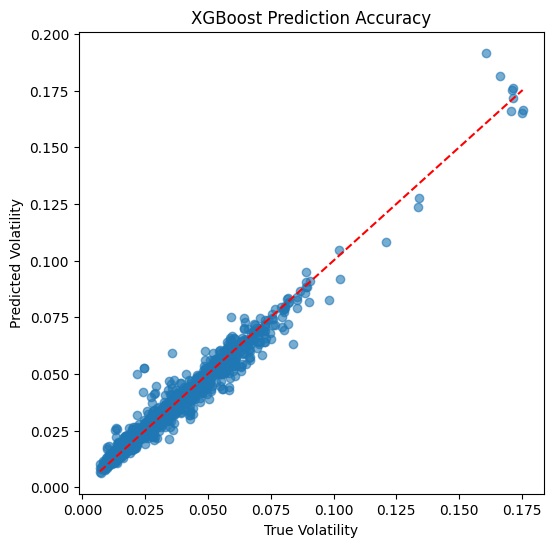

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

#setting evaluation metrics
mae = mean_absolute_error(y_test, y_pred)   #our primary metric for tuning
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²   = {r2:.4f}")

import matplotlib.pyplot as plt
#scatter plot of true future volatility (y_test) vs. model's predictions (y_pred)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("XGBoost Prediction Accuracy")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.show()

Evaluation metrics
- The average magnitude of the model's error is very small, approximately $\mathbf{0.22\%}$ in daily realized volatility. This low error rate is critical for a risk management system, as it ensures consistent and reliable alerts.
- This value is extremely close to zero. It indicates that the model's predictions cluster very tightly around the true values, and there are no large, systematic errors being heavily penalized.
- A score of $0.9657$ means that the model's nine historical features successfully explain $96.57\%$ of the variability in the future 30-day volatility. This demonstrates excellent predictive fit for our scope.
The scatter plot
The scatter plot displays the model's predictions for the future 30-day volatility compared to the actual volatility that was subsequently realized in the market.
The plot shows a tight clustering of blue points along the red dashed line across the full range of volatility (from near $0.000$ to over $0.150$). The fit is nearly perfect for volatility values below $0.100$. The model also maintains strong predictive power even in the high-volatility range (above $0.125$), where only a few points show a noticeable divergence from the red line.
The scatter plot supports the high $\mathbf{R^2}$ value achieved by the XGBoost Regressor. The strong correlation between true and predicted values demonstrates that the model generalizes well to unseen data and is reliable for us to forecast volatility.

In [15]:
import pickle    #used to convert python objects into a byte stream

#we store the XGBoost Regressor object and logic learned in training
model_package = {
    "model": xgb_tuned,
    #storing also 9 featuresin order to later pass it to lambda
    "feature_columns": X_train.columns.tolist()
}

#writing package to disk with pickle
with open("volatility_model.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("Model exported as volatility_model_XG.pkl")
print("Features:", model_package["feature_columns"])

Model exported as volatility_model_XG.pkl
Features: ['volatility_30d', 'momentum_30d', 'max_drawdown_30d', 'atr_30d', 'avg_volume_30d', 'volume_volatility_30d', 'beta_30d', 'range_ratio', 'up_down_ratio']
